Use time series model to generate hourly predictions of the features.
- Potential problem: the target prediction period (up to 18 month) is too long compared to historical data we possess (~66 month). 
-> Additional historical data would be helpful.

# Preparation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv, find_dotenv
import sys
sys.path.append('../')

In [2]:
# data directories
load_dotenv(find_dotenv(), verbose=True)
dir_project = os.getenv('PROJECT_ROOT')
dir_data_raw = os.path.join(dir_project, 'data/raw/')
dir_data_interim = os.path.join(dir_project, 'data/interim/')
dir_data_processed = os.path.join(dir_project, 'data/processed/')
dir_data_external = os.path.join(dir_project, 'data/external/')
dir_models = os.path.join(dir_project, 'models/')

Load data:  
(To be change to selected dataset)

In [3]:
path_data = os.path.join(dir_data_interim, 'Clean_Hourly_Data.csv')

In [4]:
df_origin = pd.read_csv(path_data)
df_origin.Date = pd.to_datetime(df_origin.Date + ' ' + df_origin.Hour)
df_origin.set_index('Date', inplace=True)

In [5]:
df_origin.head()

,Hour,HOEP,Ontario.Demand,NUCLEAR,GAS,HYDRO,WIND,SOLAR,BIOFUEL,Temp,Holidays,season_Fall,season_Spring,season_Summer,season_Winter,month,dayofweek,CDD,HDD
Date,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,00:00:00,3.28,14960,11564,957,3173,2504,0.0,20,-6.2,1,0,0,0,1,1,3,0.0,24.53
2015-01-01 01:00:00,01:00:00,0.00,14476,11560,946,3100,2262,0.0,20,-6.0,1,0,0,0,1,1,3,0.0,24.33
2015-01-01 02:00:00,02:00:00,0.00,13979,11560,947,3051,2025,0.0,20,-6.2,1,0,0,0,1,1,3,0.0,24.53
2015-01-01 03:00:00,03:00:00,0.00,13670,11444,949,3086,1950,0.0,22,-6.0,1,0,0,0,1,1,3,0.0,24.33
2015-01-01 04:00:00,04:00:00,0.00,13567,11174,946,3131,2015,0.0,21,-6.0,1,0,0,0,1,1,3,0.0,24.33


In [6]:
len(df_origin)

48360

In [7]:
independ_vars = ['HOEP', 'Ontario.Demand', 'Temp', 'NUCLEAR', 'GAS', 'HYDRO', 'WIND', 'SOLAR', 'BIOFUEL']
df = df_origin[independ_vars]

Leave `CDD`, `HDD` aside since it's calculated from `Temp`.

Missing `dew point` in the data.

# Visualize

Whole dataset on ~42 month (3.5 years) of data:

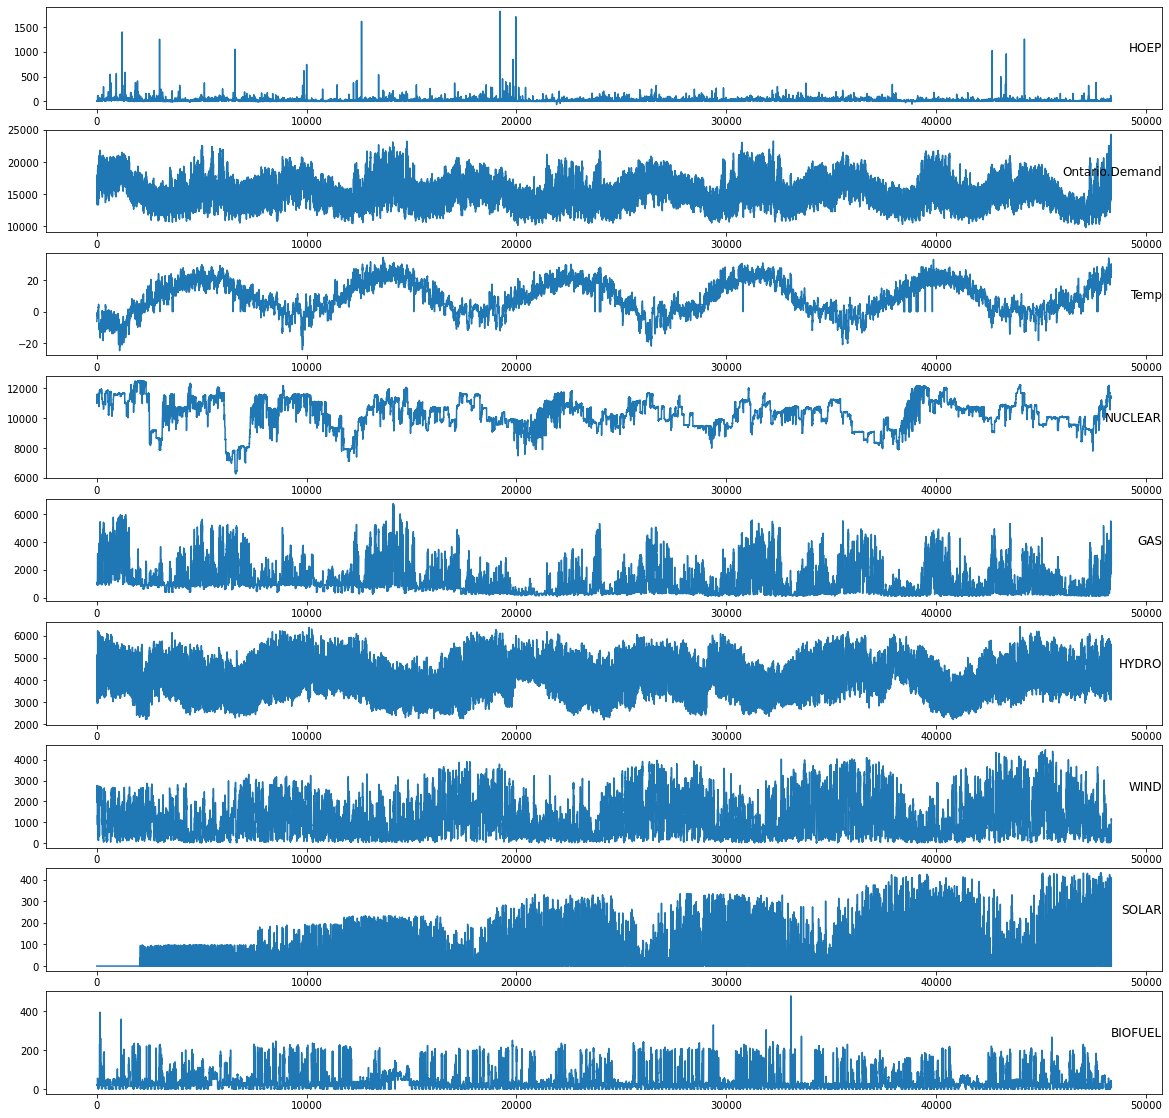

In [8]:
values = df.values
# specify columns to plot
cols = range(0, values.shape[1])
i = 1
# plot each column
plt.figure(figsize=(20, 20))
for col in cols:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[:, col])
	plt.title(df.columns[col], y=0.5, loc='right')
	i += 1
plt.show()

One month sample data:

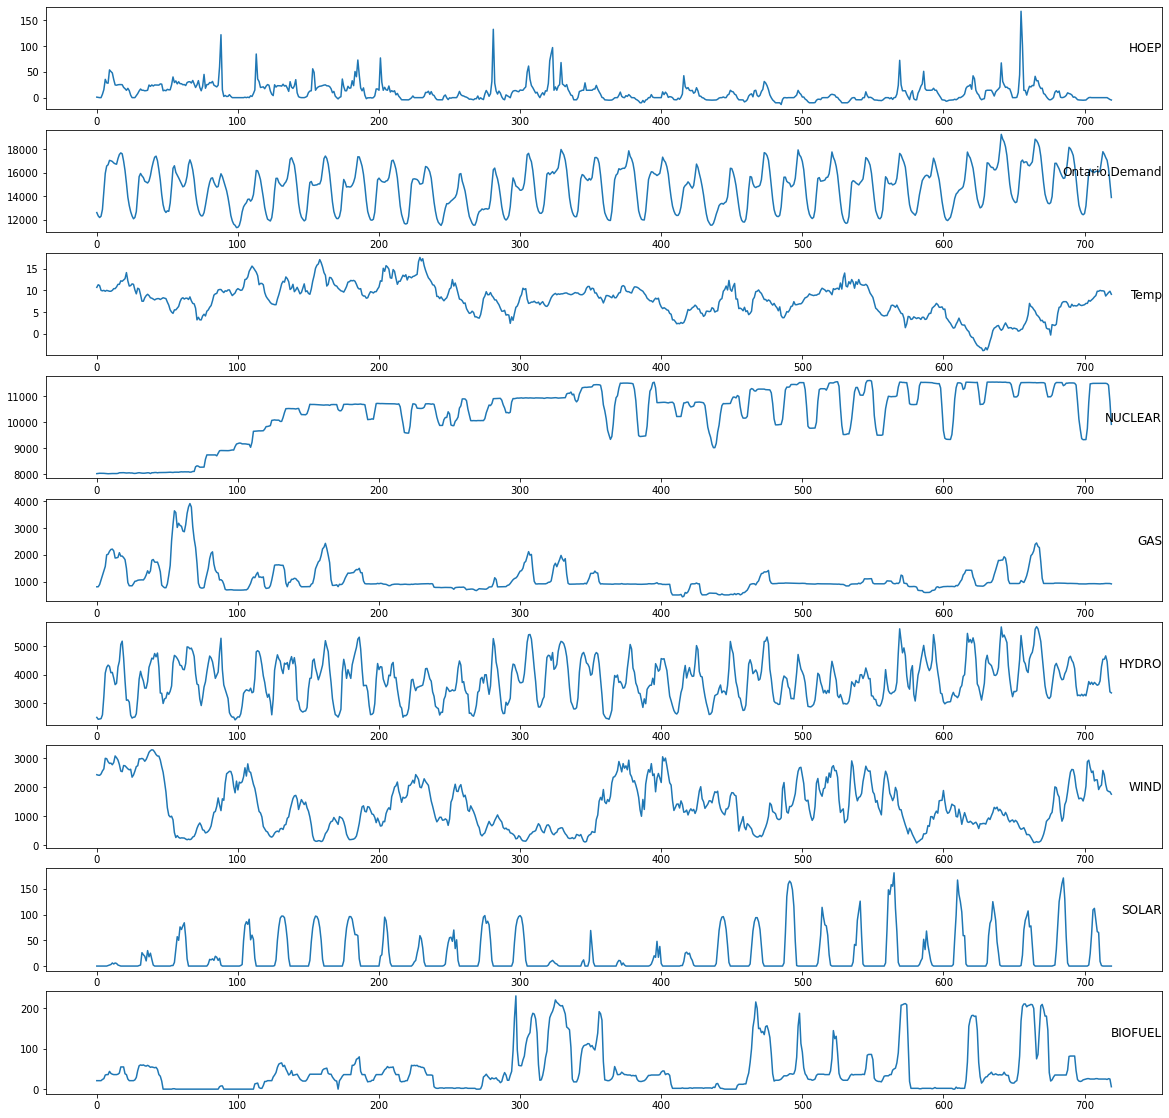

In [173]:
cols = range(0, values.shape[1])
i = 1
# plot each column
plt.figure(figsize=(20, 20))
for col in cols:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[720*10:720*11, col])
	plt.title(df.columns[col], y=0.5, loc='right')
	i += 1
plt.show()

One day sample:

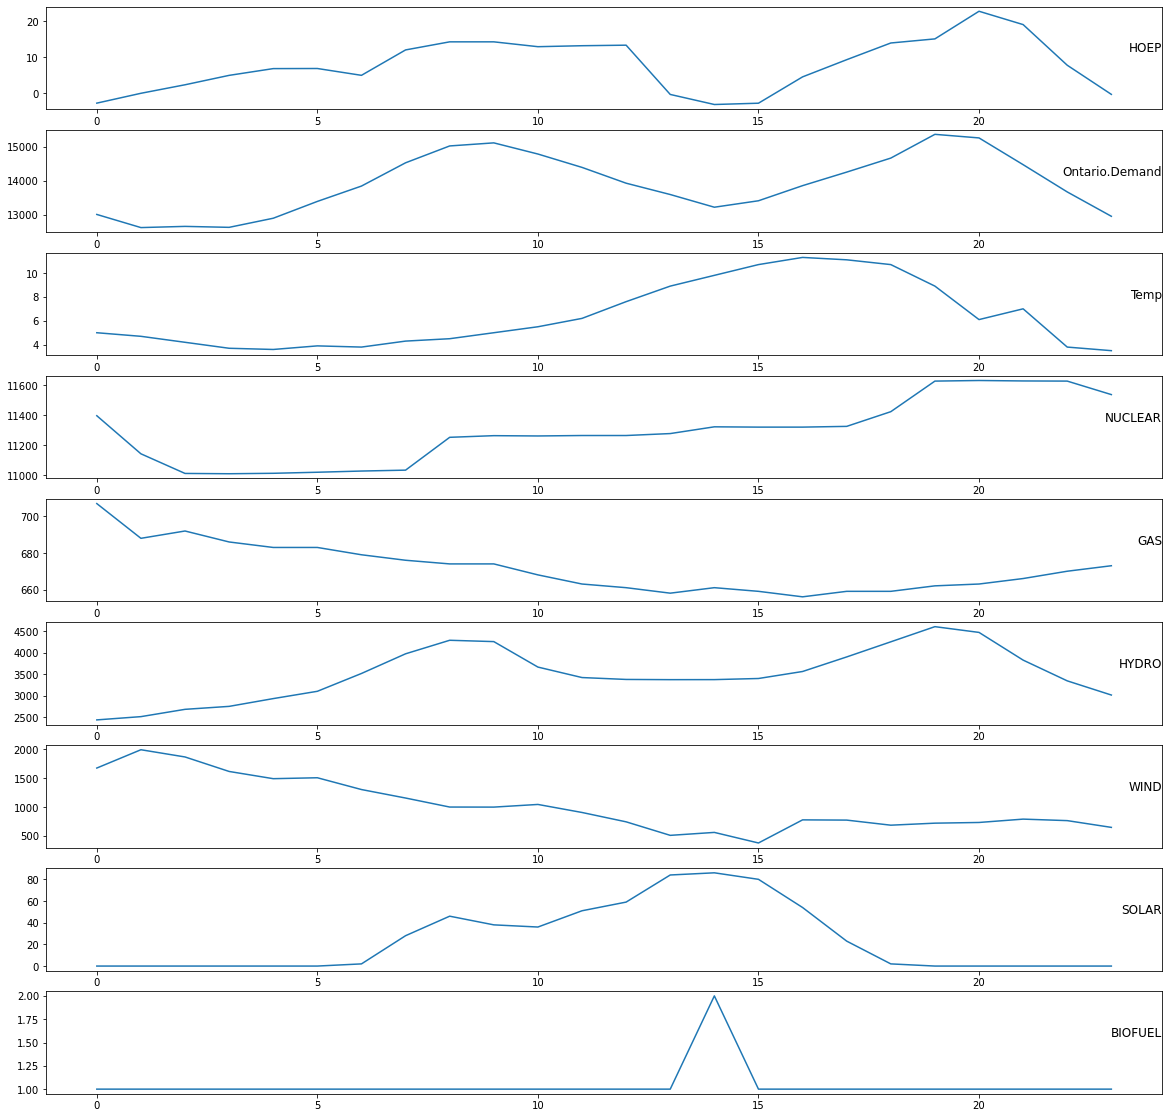

In [174]:
cols = range(0, values.shape[1])
i = 1
# plot each column
plt.figure(figsize=(20, 20))
for col in cols:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[24*100:24*101, col])
	plt.title(df.columns[col], y=0.5, loc='right')
	i += 1
plt.show()

We can find clear seasonnal and daily patterns on most of the variables.

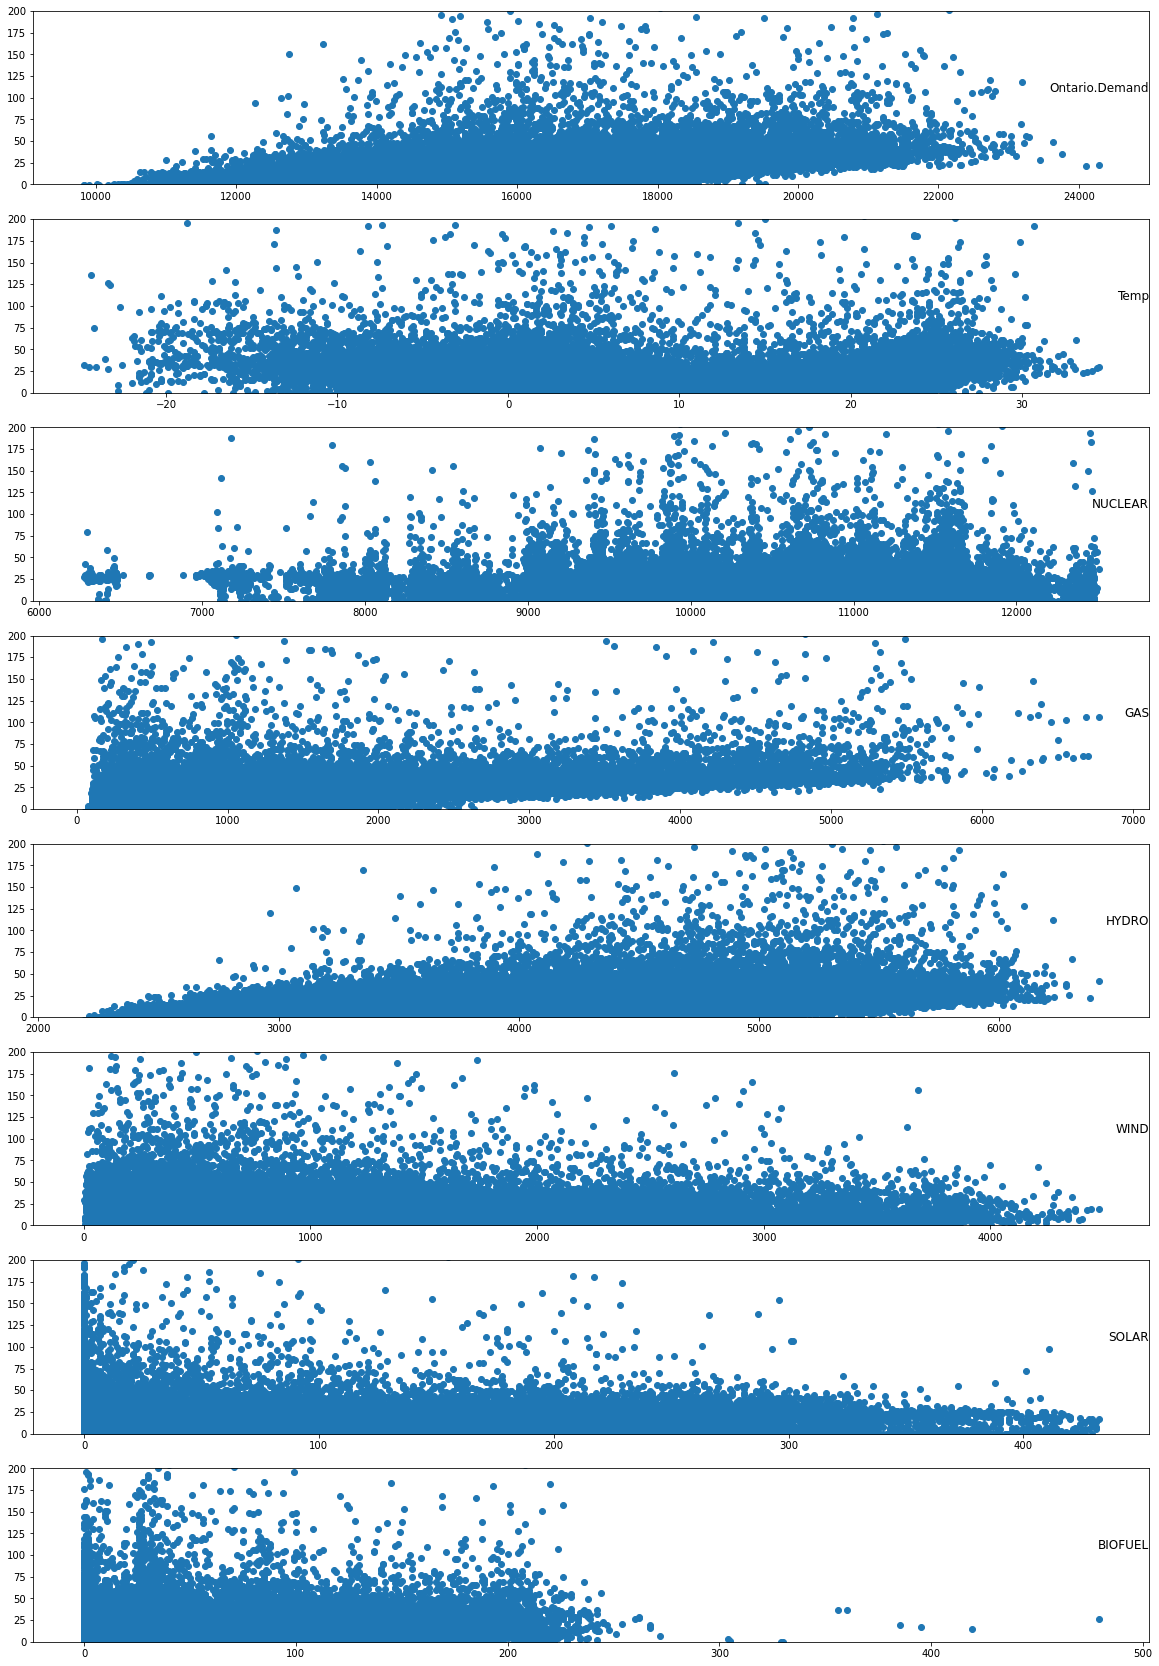

In [28]:
cols = range(1, values.shape[1])
i = 1
y = values[:, 0]
# plot each column
plt.figure(figsize=(20, 30))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.scatter(values[:, col], y)
    plt.ylim(0,200)
    plt.title(df.columns[col], y=0.5, loc='right')
    i += 1
plt.show()

References:  
1. [IVADO tutorial](https://colab.research.google.com/drive/1bD5d7l_5e5gA2AkSrLhrv7EN6OkxtN3O?usp=sharing#scrollTo=-vFcRQaHJPxy)  
2. [Modeling Long- and Short-Term Temporal Patterns with Deep
Neural Networks](https://arxiv.org/pdf/1703.07015.pdf)  
3. [VAR](https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/)

# Vector Auto Regression (VAR) model

## Feature test and process

### Test Granger’s Causality:

In [29]:
from src.features.analyze_features import grangers_causation_matrix

In [30]:
causation_matrix = grangers_causation_matrix(df, variables=df.columns, maxlag=24)

In [31]:
causation_matrix

,HOEP_x,Ontario.Demand_x,Temp_x,NUCLEAR_x,GAS_x,HYDRO_x,WIND_x,SOLAR_x,BIOFUEL_x
HOEP_y,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ontario.Demand_y,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Temp_y,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
NUCLEAR_y,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
GAS_y,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
HYDRO_y,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
WIND_y,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
SOLAR_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
BIOFUEL_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


All significant, indicating the variables my have interchangeably predictive power over each other. So, it's suitable to model it as multivariate time series.

### Stationarity

The variables are obviously none stationary:
- Daily and weekly and yearly seasonality exist for most of the variables.
- Some variables, e.g. Solar, exhibit slight upward trend.

But the `Augmented Dickey-Fuller` test below didn't work well on our dataset: too computationally expensive for long `maxlag`, while the auto-selected `maxlag` is not suitable.

### Data splitting

Train on data before 2019:

In [9]:
df_train = df_origin[df_origin.index.year < 2019][independ_vars]
df_test = df_origin[df_origin.index.year >= 2019][independ_vars]

In [10]:
print(f'Train/Test: {len(df_train)}/{len(df_test)}')
print('Test%:', len(df_test)/len(df))

Train/Test: 35064/13296
Test%: 0.2749379652605459


### Differencing 

Transform data into stationary form by seasonal differencing:

In [11]:
df_train_diff = df_train.diff(periods=365*24)

Visual exam:

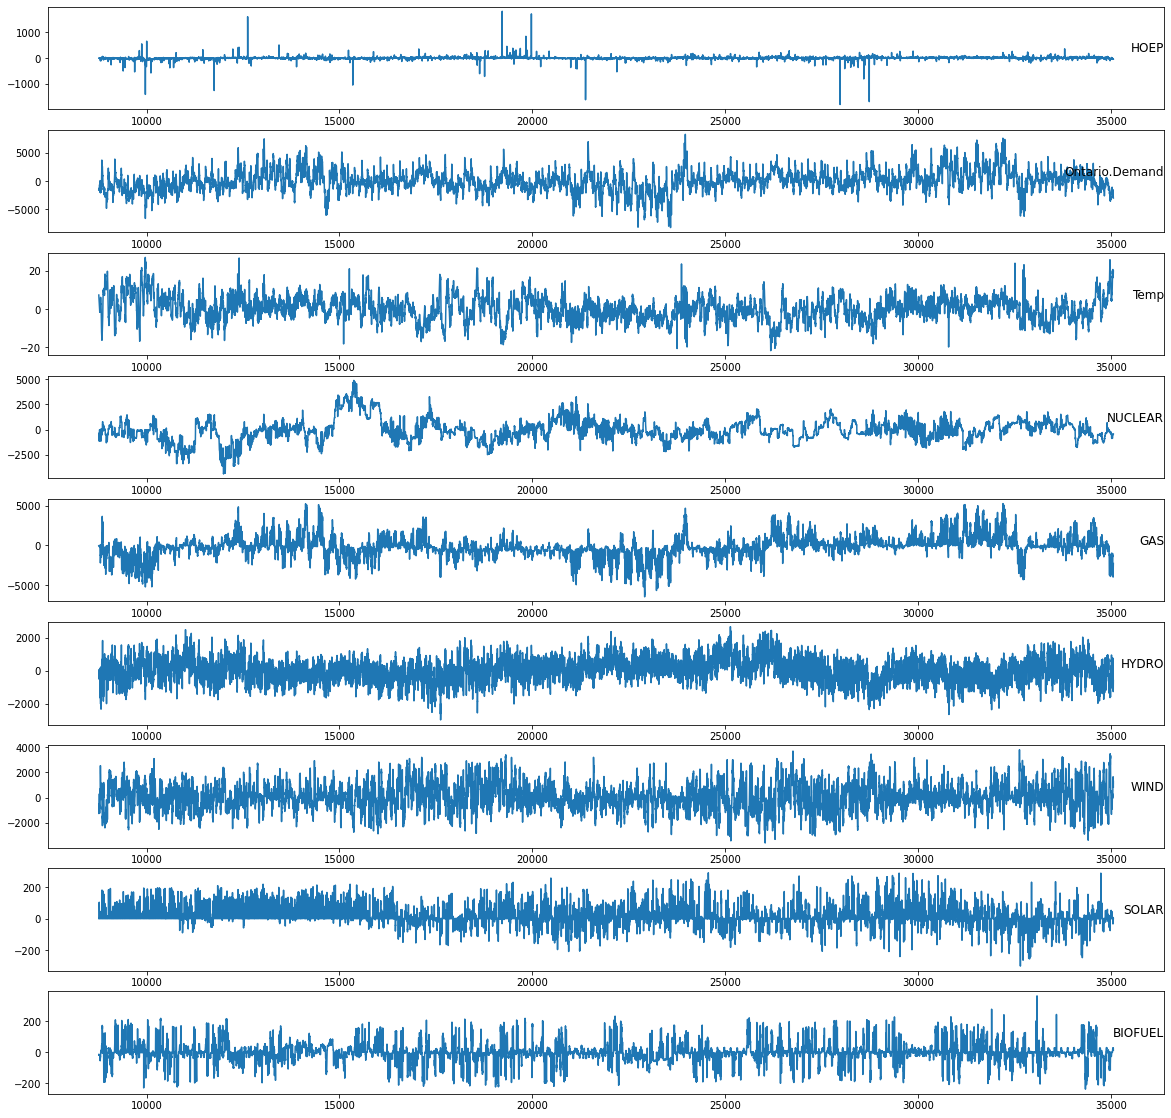

In [12]:
values = df_train_diff.values
# specify columns to plot
cols = range(0, values.shape[1])
i = 1
# plot each column
plt.figure(figsize=(20, 20))
for col in cols:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[:, col])
	plt.title(df.columns[col], y=0.5, loc='right')
	i += 1
plt.show()

## Fit the VAR model

In [13]:
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic

In [14]:
model = VAR(df_train_diff.dropna())

/project/6006766/lucecpkn/hq_hoep_prediction/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


### Select the best log order for VAR 

Too long not run!  Take too much time for longer lags.

In [33]:
for i in [100, 200, 500, 800, 1000, 2000, 4000, 10000]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 100
AIC :  80.03477757559367
BIC :  83.17735775483325
FPE :  5.738883444844604e+34
HQIC:  81.05000032784528 

Lag Order = 200
AIC :  77.63021027329117
BIC :  83.93350040263788
FPE :  5.196489485454199e+33
HQIC:  79.66688831113905 

Lag Order = 500
AIC :  75.62406622418328
BIC :  91.53935287476274
FPE :  7.331212922926842e+32
HQIC:  80.7693794907435 

Lag Order = 800
AIC :  74.72621154730052
BIC :  100.45330146449774
FPE :  3.552464729646439e+32
HQIC:  83.0483181444957 

Lag Order = 1000
AIC :  74.22439016646778
BIC :  106.60697302976678
FPE :  2.7402130695674568e+32
HQIC:  84.70337686723474 

Lag Order = 2000
AIC :  65.53067866234207
BIC :  132.6414072963195
FPE :  3.6376697857278777e+31
HQIC:  87.29007631064397 

Lag Order = 4000
AIC :  -474.0029622545758
BIC :  -329.2114314394426
FPE :  6.8574897319698226e-217
HQIC:  -426.86095194782223 

Lag Order = 10000
AIC :  -395.73669537443476
BIC :  81.3857281704071
FPE :  4.3202807991190734e-225
HQIC:  -237.9871320312808 



Lag = 4000 seems to the best choice among the above.

In [16]:
for i in [3000, 5000, 6000]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 3000
AIC :  -455.7418913406156
BIC :  -351.2718042120139
FPE :  4.670494002828647e-201
HQIC:  -421.80035805584777 

Lag Order = 5000
AIC :  -468.6678030396138
BIC :  -280.20256928343895
FPE :  6.323172880002512e-221
HQIC:  -407.16904726522404 

Lag Order = 6000
AIC :  -458.49392152735965
BIC :  -222.5391557548196
FPE :  9.86569976545299e-223
HQIC:  -381.3177728577193 



We take lag = 4000 then.

### Fit Model

In [83]:
lag = 2000
model_fitted = model.fit(lag)
# model_fitted.summary()  # too long, not run

Long to train, save it:

In [44]:
import pickle
import time
timestr = time.strftime("%Y%m%d-%H%M")
# pickle.dump(model_fitted, open(os.path.join(dir_models, f"VAR_lag{lag}_{timestr}.pkl"), "wb"))
# timestr = '20200824-2003'
# model_fitted = pickle.load(open(os.path.join(dir_models, f"VAR_lag{lag}_{timestr}.pkl"), "rb"))

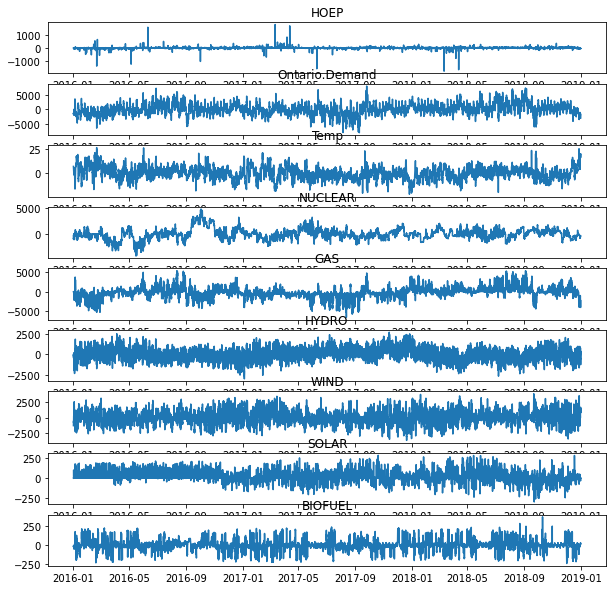

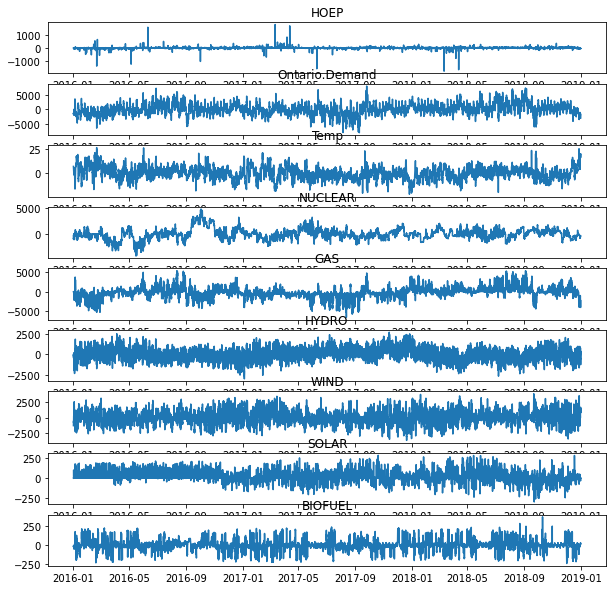

In [63]:
model_fitted.plot()

### Check Serial Correlation of Residuals (Errors)

In [84]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

def adjust(val, length= 6): 
    return str(val).ljust(length)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

HOEP   : 2.0
Ontario.Demand : 2.0
Temp   : 2.0
NUCLEAR : 2.0
GAS    : 2.0
HYDRO  : 2.0
WIND   : 2.0
SOLAR  : 2.0
BIOFUEL : 2.0


## Predict and evaluate

### Make VAR forecast

In [85]:
forecast_input = df_train_diff.values[-lag:]

In [86]:
forecast_input.shape

(2000, 9)

In [87]:
len_test =  len(df_test)
fc = model_fitted.forecast(y=forecast_input, steps=len_test)

In [88]:
fc

array([[-7.29561645e+01, -3.54486990e+03,  2.03491987e+01, ...,
         1.16481301e+03, -2.38087169e+01, -1.14246921e+01],
       [ 7.05471006e-01, -3.43242751e+03,  2.35919928e+01, ...,
         1.88218304e+03, -1.79693271e+01, -2.19784113e+01],
       [-5.41541828e+01, -3.04139558e+03,  2.09798468e+01, ...,
         1.99785195e+03, -5.03431893e+01, -3.15439172e+01],
       ...,
       [ 1.34065544e+01,  8.13681297e+02,  1.77541315e+00, ...,
         4.89868217e+02, -7.00050790e+00, -8.13749081e-01],
       [-4.55965951e+00,  6.51957328e+02,  2.39614178e+00, ...,
         6.41609808e+02, -1.20459413e+01,  2.86611753e+00],
       [-1.20168936e+01,  4.89559151e+02,  2.47769411e+00, ...,
         8.03255420e+02, -1.70230317e+01,  9.92582943e+00]])

In [89]:
df_forecast = pd.DataFrame(fc, index=df_origin.index[-len_test:], columns=df.columns)

In [90]:
df_forecast

,HOEP,Ontario.Demand,Temp,NUCLEAR,GAS,HYDRO,WIND,SOLAR,BIOFUEL
Date,,,,,,,,,
2019-01-01 00:00:00,-72.956165,-3544.869901,20.349199,-820.378602,-1753.720080,-1012.652700,1164.813007,-23.808717,-11.424692
2019-01-01 01:00:00,0.705471,-3432.427511,23.591993,-1069.212480,-1495.623713,-1436.076723,1882.183044,-17.969327,-21.978411
2019-01-01 02:00:00,-54.154183,-3041.395581,20.979847,-1047.395785,-1429.083540,-1762.352356,1997.851950,-50.343189,-31.543917
2019-01-01 03:00:00,-30.032251,-2866.601851,20.665803,-904.334784,-867.250345,-470.836461,1261.567655,-27.930472,-45.198514
2019-01-01 04:00:00,19.094279,-2351.943405,18.203417,-790.883641,-433.229810,298.834790,332.850697,-49.617450,-51.648698
...,...,...,...,...,...,...,...,...,...
2020-07-07 19:00:00,31.896654,780.544003,0.883870,-190.681402,-17.971460,379.208901,145.116011,-3.127594,9.816816
2020-07-07 20:00:00,27.411011,784.948645,0.436332,-209.170664,-87.895913,302.061720,260.386691,-5.364847,6.879352
2020-07-07 21:00:00,13.406554,813.681297,1.775413,-203.467244,-224.214904,215.759169,489.868217,-7.000508,-0.813749


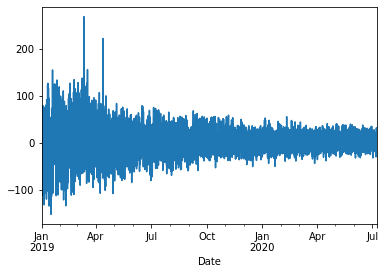

In [91]:
df_forecast['HOEP'].plot()

### Invert differentiation to restore real forecast

In [92]:
df_fc_restore = df_forecast.copy()

In [93]:
def restore(df_fc, df_tr, lag):
    df_restore = df_fc.copy()
    df_restore = df_restore.join(df_tr[-lag:], how='outer', lsuffix='_diff')
    
    df_restore.reset_index(inplace=True)
    
    for col in df_tr.columns:
        print(f'Processing col {col}...')
        for i, row in df_restore[lag:].iterrows():
            df_restore.loc[i, col] = df_restore.loc[i, col+'_diff'] + df_restore.loc[i-lag, col]
            
    df_restore = df_restore.loc[lag: , ['Date'] + list(df_tr.columns)]
    
    return df_restore.set_index('Date')

In [94]:
df_fc = restore(df_fc_restore, df_train, lag=365*24)

Processing col HOEP...
Processing col Ontario.Demand...
Processing col Temp...
Processing col NUCLEAR...
Processing col GAS...
Processing col HYDRO...
Processing col WIND...
Processing col SOLAR...
Processing col BIOFUEL...


HOEP


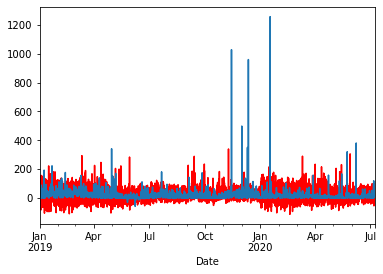

Ontario.Demand


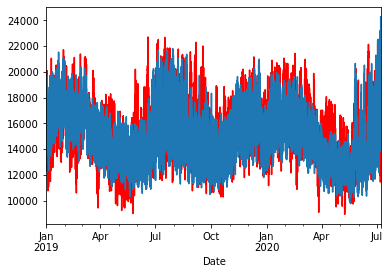

Temp


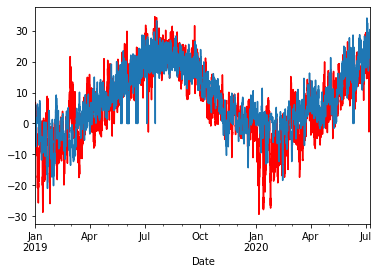

NUCLEAR


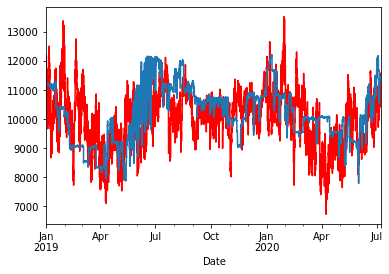

GAS


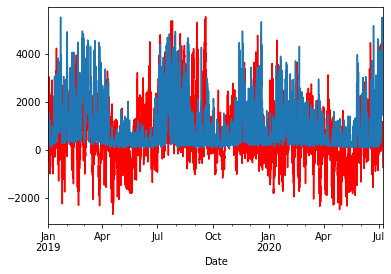

HYDRO


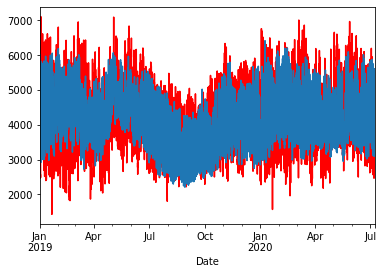

WIND


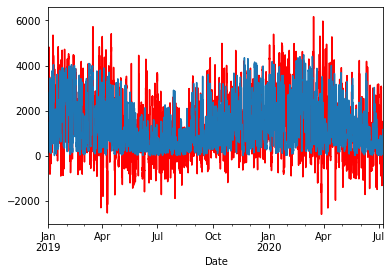

SOLAR


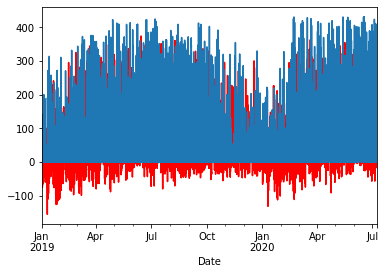

BIOFUEL


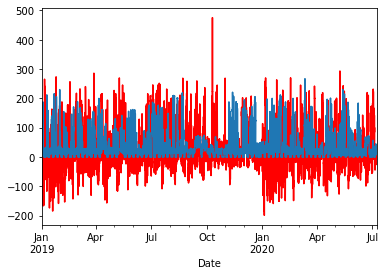

In [95]:
df_to_plot = df_fc
for col in df_to_plot.columns:
    df_to_plot[col].plot(color='r')
    df_test[col].plot()
    print(col)
    plt.show()

Look into samples:

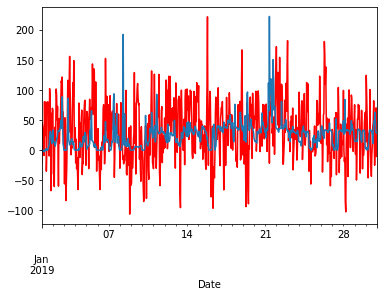

In [100]:
df_to_plot['HOEP'][:24*30].plot(color='r')
df_test['HOEP'][:24*30].plot()

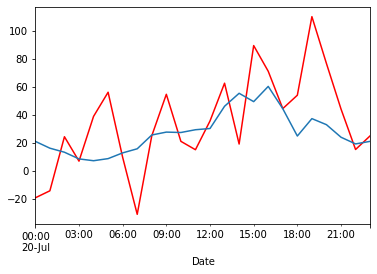

In [101]:
df_to_plot['HOEP'][24*200:24*201].plot(color='r')
df_test['HOEP'][24*200:24*201].plot()

Check other variables:

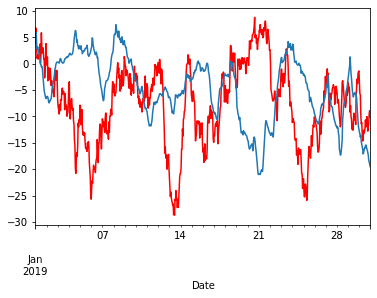

In [102]:
df_to_plot['Temp'][:24*30].plot(color='r')
df_test['Temp'][:24*30].plot()

### Output prediction

In [47]:
df_fc.to_csv(os.path.join(dir_data_processed, f"prediction_VAR_lag{lag}_{timestr}.csv"))

In [49]:
df_fc.columns

Index(['HOEP', 'Ontario.Demand', 'Temp', 'NUCLEAR', 'GAS', 'HYDRO', 'WIND',
       'SOLAR', 'BIOFUEL'],
      dtype='object')

# Observation

When `lag` too large, i.g. 4000, the differenced prediction will diverge with time, making the final prediction to diverge to unrealistic large values.  
When the `lag` is small, i.g. ~1000 or under, the differenced prediction will converge to zero, making the final prediction essentially copying the historical period.  
Thus it seems impractical for VAR to prediction in such a long term.